In [1]:
import numpy as np

from MAGPy_RV import MCMC_aux.get_model as get_model
from MAGPy_RV import Parameters as par
from MAGPy_RV import Models as mod
from MAGPy_RV import Kernels as ker
from MAGPy_RV import GP_Likelihood as gp
from MAGPy_RV import MCMC.run_MCMC as run
from MAGPy_RV import plotting as plot
from MAGPy_RV import saving.save as save
from MAGPy_RV import auxiliary as aux

2813.2308006313287 16620.585819951895


## Creating fake data to work with
A cosine with a small jitter term is created as a fake set of data, this will act as the activity to model our kernel from

In [2]:
# time array with 20 values
time = np.arange(0,20,1)
# set up the amplitude and period of the cosine
A = 10.
P = 5.
err = []
# set up a random jitter to add to the data
for i in time:
    err.append(np.random.uniform(-3,3))
# generate the rvs and errors
rv = A*np.cos(time*((2*np.pi)/P))+err
rv_err = np.ones_like(rv)*3

data_plot function will take the time, rv data, and rv errors and plot a scatter graph of the data. Axis labels, legend, and saving can all be controlled from the function inputs.

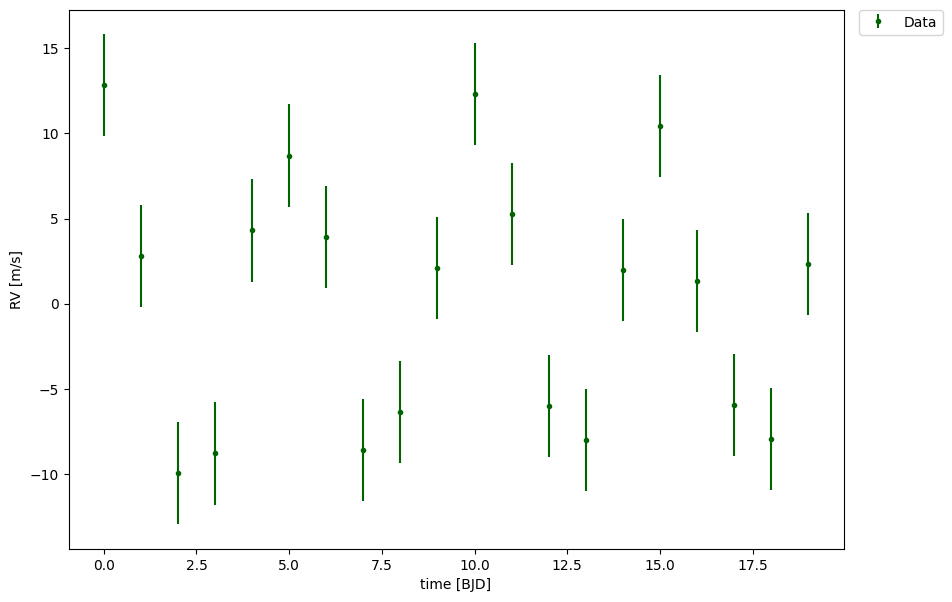

In [3]:
plot.data_plot(time = time, rv = rv, y_err = rv_err)

## Creating the kernel
A kernel must be created using the par_create function, this will take only the name of the kernel and return an empty dictionary of hyperparameters to be filled out. This dictionary can be printed to view the hyperparamer names.

Currently available kernels along with their hyperparameter names can be viewed by running PrintKernelList:

In [4]:
ker.PrintKernelList()

Implemented kernels:
{'Cosine': ['gp_amp', 'gp_per'], 'ExpSquared': ['gp_amp', 'gp_timescale'], 'ExpSinSquared': ['gp_amp', 'gp_timescale', 'gp_per'], 'QuasiPer': ['gp_per', 'gp_perlength', 'gp_explength', 'gp_amp'], 'JitterQuasiPer': ['gp_per', 'gp_perlength', 'gp_explength', 'gp_amp', 'gp_jit'], 'Matern5/2': ['gp_amp', 'gp_timescale'], 'Matern3/2': ['gp_amp', 'gp_timescale', 'gp_jit']}


In [5]:
# create the kernel
hparam = par.par_create("Cosine")
# print the hyperparameter dictionary
print(hparam)

{'gp_amp': 'gp_amp', 'gp_per': 'gp_per'}


Hyperparameters must then be assigend to each dictionary key using the parameter function. This function will also take errors and vary as inputs which will be used for the mcmc.

In [6]:
# assign values to the dictionary
hparam["gp_amp"] = par.parameter(value = 10.)
hparam["gp_per"] = par.parameter(value = 5.)
# printing now prints the filled dictionary
print(hparam)

{'gp_amp': Parameter object: value = 10.0, error=2.0 (vary = True) 
, 'gp_per': Parameter object: value = 5.0, error=1.0 (vary = True) 
}


Priors should then be created by assigning the pri_create function to each prior and appeding it to a list of priors. The pri_create function takes the parameter name, the prior name, and the prior parameters as inputs which must be inputted in the correct form, this form can be viewed by running the PRINTPRIORDER function.

In [7]:
# view the correct form of prior parameter inputs
par.PRINTPRIORDER()

Gaussian: List should take the form [mu, sigma] where all values are floats or ints 
Jeffery: List should take the form [minval, maxval] where all values are floats or ints 
Modified Jeffery: List should take the form [minval, maxval, kneeval] where all values are floats or ints 
Uniform: List should take the form [minval, maxval] where all values are floats or ints


In [8]:
# create empty prior list
prior_list = []
# uniform parameters used here so prior parameters inputted as [minval, maxval], as the above function states
pri_amp = par.pri_create("gp_amp", "Uniform", [5.,15.])
# then append the prior to the list
prior_list.append(pri_amp)
pri_per = par.pri_create("gp_per", "Uniform", [0.,10.])
prior_list.append(pri_per)
# print the list of all the priors
print(prior_list)

[('gp_amp', 'Uniform', {'minval': 5.0, 'maxval': 15.0}), ('gp_per', 'Uniform', {'minval': 0.0, 'maxval': 10.0})]


## Obtaining LogL and GP values
The GPLikelihood class should be defined and run with the time data, the rv data, the rv errors, the hyperparameters, and the kernel name. This allows the GPLikelihood.LogL function to be run with the prior_list which returns the initial log likelihood of the GP model.

In order to return the y values and errors of the GP model, a predicted x array must first be defined which should be smoother and longer than the initial time array, in this case it begins at -1 and ends at 21 with intervals of 0.1 which is around 10 times more data points than the initial time array. This must be then inputted into the GPLikelihood.predict function to return the y values and the errors of the GP.

In [9]:
# GPLikelihood class called as loglik, run with the current inputs
loglik = gp.GPLikelihood(time, rv, rv_err, hparam, "Cosine")
# LogL obtained by running loglik.LogL with the prior_list as the only input
logL = loglik.LogL(prior_list)
# xpred is smoother and longer than time
xpred = np.arange(min(time)-1, max(time)+1, 0.1)
# GP_y and GP_err are arrays of the GP y values and errors of the same length as the xpred array
GP_y, GP_err = loglik.predict(xpred)
print('Initial Log Likelihood =', logL)

Initial Log Likelihood = -47.97958115218286


## Plotting the GP
The GP y values could be manually plotted against xpred once obtained in the previous step however the GP_plot function allows for an alternative faster way of plotting. This function takes the time array, the rv data, the hyperparameters, the kernel name, and the rv errors and returns a plot of the data with the GP model plotted over it. Xpred, axis labels, residuals, legend, and saving can all be controlled by the function inputs.

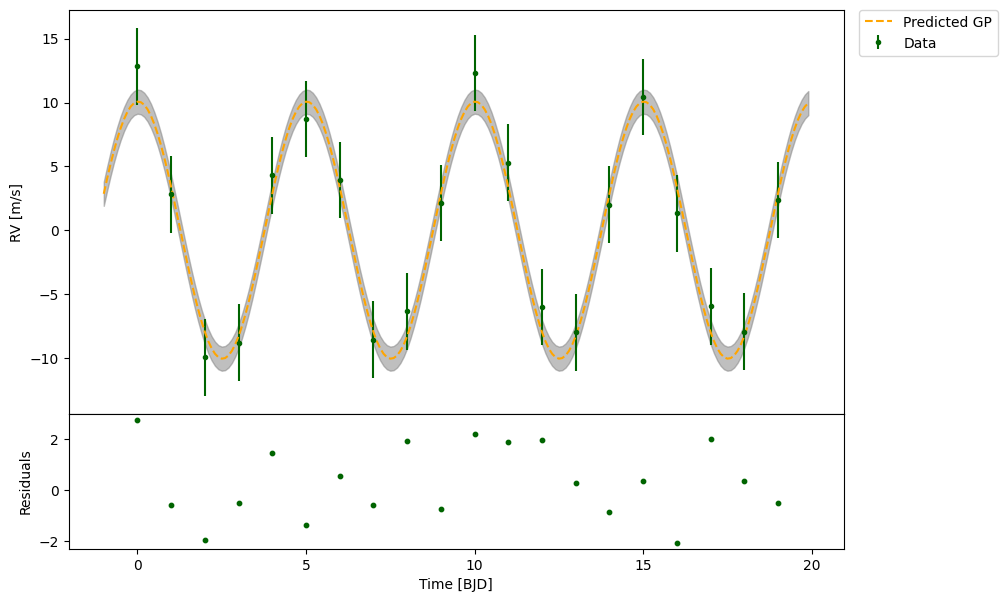

In [10]:
# GP_plot will plot the GP and the data along with residuals if enabled and the GP uncertainty in grey
plot.GP_plot(time, rv, hparam, "Cosine", rv_err = rv_err, residuals = True)